In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
import joblib
import shap
from sklearn.metrics import f1_score
import re
import seaborn as sns
shap.initjs()
import sys
from itertools import combinations
sys.path.append('./scrape.py')
import scrape
import networkx as nx
from matplotlib import cm

os.chdir("../../Dataset/Merged")

dataset = pd.read_csv('MergedDataset-136411.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

ensembleSelected = joblib.load('../../Modelli/DatasetReduced/ensembleSelected_373.pkl')

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])
x_train = x_train[list(ensembleSelected.feature_names_in_)]

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])
x_test = x_test[list(ensembleSelected.feature_names_in_)]

x_train = x_train[ensembleSelected.feature_names_in_]
x_test = x_test[ensembleSelected.feature_names_in_]

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data
Dataset di train:
(1340, 12094)
I malati sono:  521
I sani sono:  819

Dataset di test:
(464, 12094)
I malati sono:  177
I sani sono:  287


In [18]:
print(ensembleSelected.score(x_train, y_train))
print(ensembleSelected.score(x_test, y_test))
print(classification_report(y_test, ensembleSelected.predict(x_test)))

1.0
0.9547413793103449
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       287
           1       0.93      0.95      0.94       177

    accuracy                           0.95       464
   macro avg       0.95      0.95      0.95       464
weighted avg       0.96      0.95      0.95       464



<h1> Shap Values </h1>

In [2]:
shap_object = joblib.load('../../ShapValues/DatasetReduced/ensembleSelected_shapValues.pkl')
shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_dictSummary = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

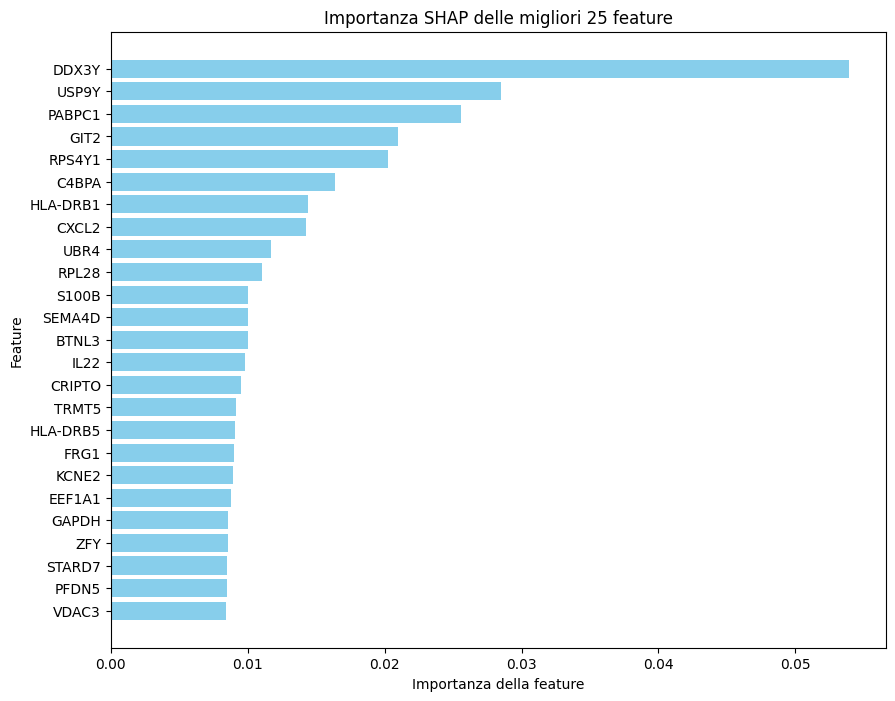

In [21]:
plt.figure(figsize=(10, 8))
plt.barh(list(expl_sorted.keys())[:25][::-1], list(expl_sorted.values())[:25][::-1], color='skyblue')
plt.xlabel('Importanza della feature')
plt.ylabel('Feature')
plt.title('Importanza SHAP delle migliori 25 feature')
plt.show()

<h1>Ablation</h1>

In [ ]:
def calcScores(x_test, y_test, model):
    scores = {col: 0 for col in x_test.columns}
    i = 1
    for exclude in range(x_train.shape[1]):
        x = x_test.copy()
        x[x.columns[exclude]] = x[x.columns[exclude]].mean()
        scores[x.columns[exclude]] = f1_score(y_test, model.predict(x))
        print(i)
        i += 1
    return scores

scores = calcScores(x_test, y_test, ensembleSelected)
joblib.dump(scores, '../../ShapValues/DatasetReduced/ensembleSelected_ablationScoresPURI.pkl')

original = f1_score(y_test, ensembleSelected.predict(x_test))
new_scores = {key: original/value for key, value in scores.items()}
joblib.dump(new_scores, '../../ShapValues/DatasetReduced/ensembleSelected_ablationScores.pkl')


In [3]:
scores = joblib.load('../../ShapValues/DatasetReduced/ensembleSelected_ablationScoresPURI.pkl')
print(scores)

{'DDX3Y': 0.9362880886426593, 'USP9Y': 0.9415041782729805, 'GIT2': 0.9411764705882353, 'PABPC1': 0.9261363636363636, 'RPS4Y1': 0.9415041782729805, 'C4BPA': 0.9415041782729805, 'HLA-DRB5': 0.938888888888889, 'HLA-DRB1': 0.9247910863509751, 'UBR4': 0.9362880886426593, 'CRIPTO': 0.9415041782729805, 'S100B': 0.9444444444444445, 'CXCL2': 0.9415041782729805, 'PFDN5': 0.9411764705882353, 'IL22': 0.9415041782729805, 'ZFY': 0.9415041782729805, 'KCNE2': 0.9415041782729805, 'BTNL3': 0.9415041782729805, 'EEF1A1': 0.9441340782122905, 'GABRB2': 0.9415041782729805, 'HNRNPA1': 0.9362880886426593, 'LALBA': 0.9415041782729805, 'AREG': 0.9415041782729805, 'RPL13A': 0.9411764705882353, 'RPS3': 0.9415041782729805, 'USP25': 0.938888888888889, 'RPS29': 0.9415041782729805, 'TRMT5': 0.9337016574585636, 'SEMA4D': 0.9418282548476454, 'VDAC3': 0.938888888888889, 'RPL28': 0.9362880886426593, 'NIPSNAP3B': 0.938888888888889, 'FRG1': 0.9415041782729805, 'RPS28': 0.9415041782729805, 'APOO': 0.9362880886426593, 'GLRA2'

In [3]:
new_scores = joblib.load('../../ShapValues/DatasetReduced/ensembleSelected_ablationScores.pkl')
sorted_scores = dict(sorted(new_scores.items(), key=lambda item: item[1], reverse=True))
bestFeatures = {key: value for key, value in sorted_scores.items() if value > 1.0}
worstFeatures = {key: value for key, value in sorted_scores.items() if value < 1.0}
print("Le feature migliori sono: ", len(bestFeatures), bestFeatures)
print("Le feature rumorose sono: ", len(worstFeatures), worstFeatures)

print(list(bestFeatures.keys()))

Le feature migliori sono:  38 {'HLA-DRB1': 1.0180722891566263, 'PABPC1': 1.0165934685646907, 'SPATA1': 1.009157173118943, 'TRMT5': 1.0083565459610027, 'DDX3Y': 1.0055710306406684, 'UBR4': 1.0055710306406684, 'HNRNPA1': 1.0055710306406684, 'RPL28': 1.0055710306406684, 'APOO': 1.0055710306406684, 'SIT1': 1.0055710306406684, 'PHB2': 1.0055710306406684, 'GLRA2': 1.0031502851837113, 'EXOSC8': 1.0031502851837113, 'APOC1': 1.0031502851837113, 'CLEC2B': 1.0031502851837113, 'FSHB': 1.0031502851837113, 'HLA-DRB5': 1.0027855153203342, 'USP25': 1.0027855153203342, 'VDAC3': 1.0027855153203342, 'NIPSNAP3B': 1.0027855153203342, 'CTNNBL1': 1.0027855153203342, 'RAB5IF': 1.0027855153203342, 'STARD7': 1.0027855153203342, 'PPIA': 1.0027855153203342, 'JPT1': 1.0027855153203342, 'BAZ1B': 1.0027855153203342, 'MIR22HG': 1.0027855153203342, 'RPS2': 1.0027855153203342, 'FKBP11': 1.0027855153203342, 'LRRC59': 1.0027855153203342, 'APOBEC3F': 1.0027855153203342, 'TMED5': 1.0027855153203342, 'GALNT1': 1.00278551532

<h1>Matrici di correlazione</h1>

Correlazione tra migliori 100 shap values sulla matrice di importanze

In [4]:
ensembleCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()
print(ensembleCorr)

            DDX3Y     USP9Y    PABPC1      GIT2    RPS4Y1     C4BPA  HLA-DRB1  \
DDX3Y    1.000000  0.847568  0.662025  0.598111  0.776349  0.687059  0.234587   
USP9Y    0.847568  1.000000  0.607681  0.472951  0.558495  0.537836  0.251349   
PABPC1   0.662025  0.607681  1.000000  0.303404  0.528999  0.274302  0.277753   
GIT2     0.598111  0.472951  0.303404  1.000000  0.514503  0.563902  0.178594   
RPS4Y1   0.776349  0.558495  0.528999  0.514503  1.000000  0.577190  0.140394   
...           ...       ...       ...       ...       ...       ...       ...   
TMEM242  0.101061  0.088367  0.134691  0.079790  0.090400  0.013689 -0.019984   
TRAPPC9 -0.004881 -0.036627 -0.013331  0.096319 -0.008566  0.000618  0.011545   
RPS3     0.122835  0.131460  0.112252  0.017467  0.118305  0.023221  0.101314   
RAX      0.012533  0.029845  0.064869 -0.029334  0.004206 -0.056048 -0.081076   
SOX3     0.074883  0.091997 -0.007718  0.057129  0.004561  0.093717  0.023675   

            CXCL2      UBR4

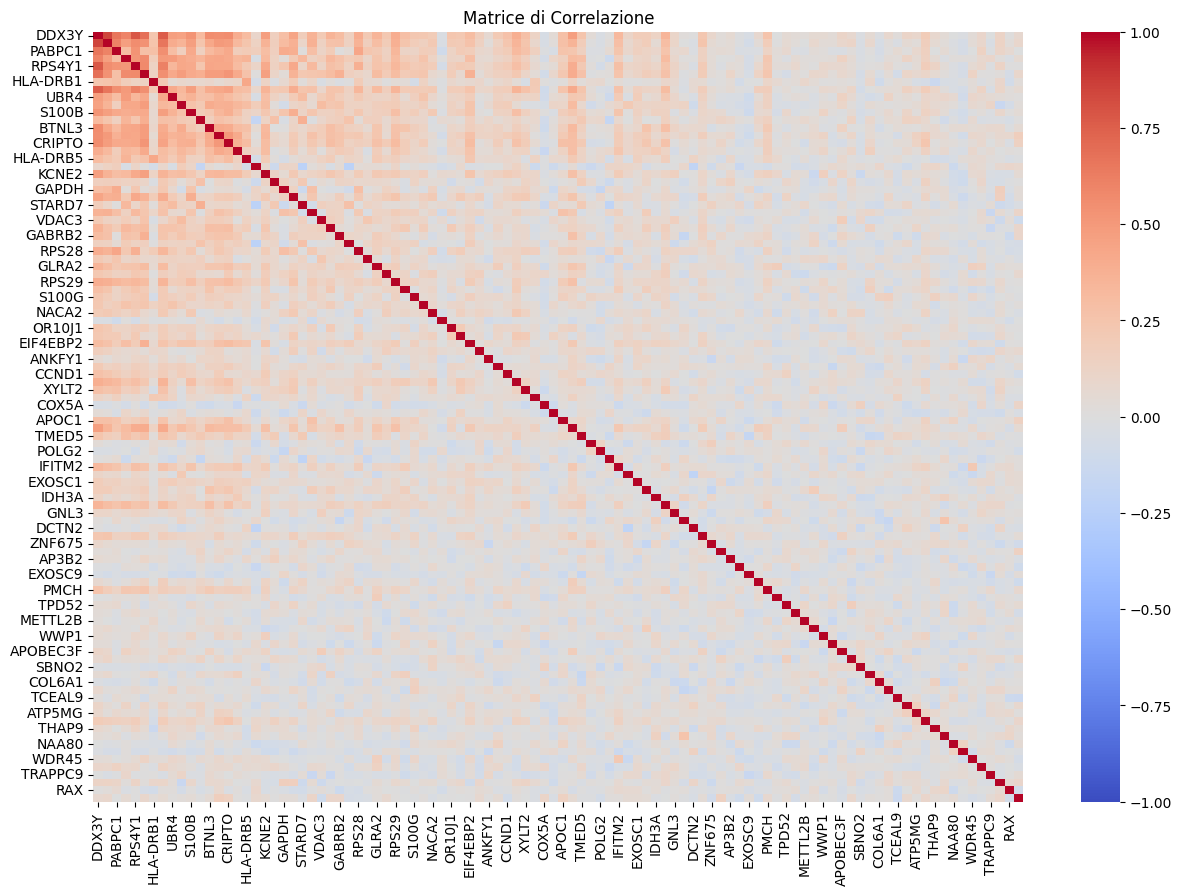

In [24]:
plt.figure(figsize=(15,10))
sns.heatmap(ensembleCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [7]:
ensemble_correlated_pairs = np.where(np.abs(ensembleCorr) >= 0.4)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{ensembleCorr.index[i]} - {ensembleCorr.columns[j]}: {ensembleCorr.iloc[i, j]}")

retrieveGenes = []
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        if ensembleCorr.index[i] not in retrieveGenes:
            retrieveGenes.append(ensembleCorr.index[i])

print(retrieveGenes)

DDX3Y - USP9Y: 0.8475681036912219
DDX3Y - PABPC1: 0.6620247113014083
DDX3Y - GIT2: 0.5981107478672828
DDX3Y - RPS4Y1: 0.7763493614959456
DDX3Y - C4BPA: 0.6870591351315187
DDX3Y - CXCL2: 0.7643142945588547
DDX3Y - UBR4: 0.47638947775557033
DDX3Y - RPL28: 0.45905959668394275
DDX3Y - S100B: 0.5236315289220925
DDX3Y - BTNL3: 0.5564362577266461
DDX3Y - IL22: 0.554562673417902
DDX3Y - CRIPTO: 0.5579635848340583
DDX3Y - KCNE2: 0.472576380564465
DDX3Y - ZFY: 0.44284583483917483
DDX3Y - UGT2B28: 0.4711874091883429
USP9Y - DDX3Y: 0.8475681036912219
USP9Y - PABPC1: 0.607681137878457
USP9Y - GIT2: 0.4729511624461
USP9Y - RPS4Y1: 0.5584953039882069
USP9Y - C4BPA: 0.5378363177897717
USP9Y - CXCL2: 0.6581666484744708
USP9Y - UBR4: 0.40248944901060446
USP9Y - S100B: 0.47089146260031445
USP9Y - BTNL3: 0.4276048161019819
USP9Y - IL22: 0.49312424310659586
USP9Y - CRIPTO: 0.4813275225240805
PABPC1 - DDX3Y: 0.6620247113014083
PABPC1 - USP9Y: 0.607681137878457
PABPC1 - RPS4Y1: 0.5289989743666508
PABPC1 - CX

Correlazione tra intersezione migliori shap e ablation

{'RPL28', 'APOBEC3F', 'TRMT5', 'PABPC1', 'NACA2', 'PPIA', 'USP25', 'PFDN5', 'HLA-DRB1', 'DDX3Y', 'CLEC2B', 'LRRC59', 'NIPSNAP3B', 'UBR4', 'GLRA2', 'APOC1', 'HNRNPA1', 'HLA-DRB5', 'VDAC3', 'STARD7', 'SPATA1', 'TMED5', 'GIT2', 'GAPDH', 'RAB5IF'}


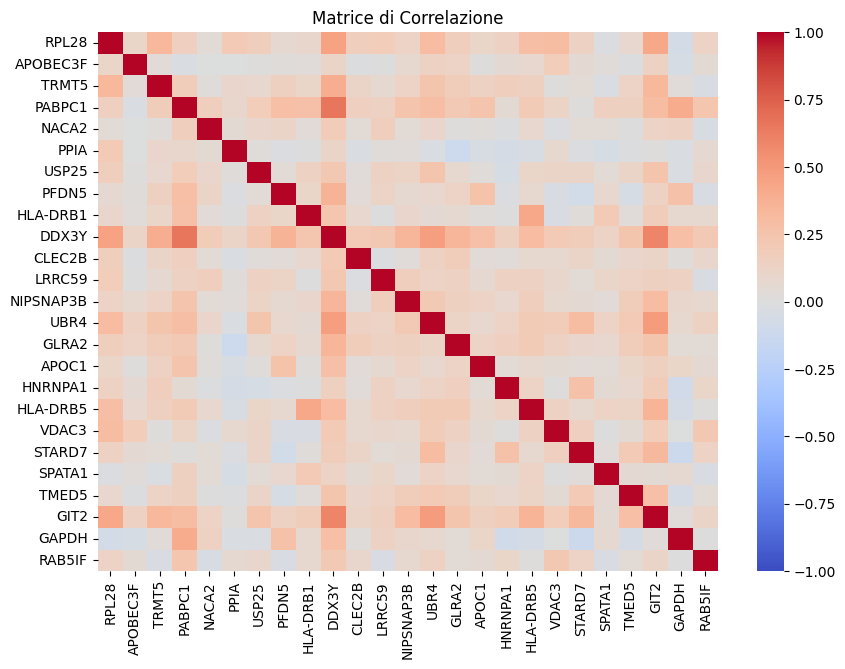

In [7]:
intersect = set(list(expl_sorted.keys())[:100]) & set(bestFeatures.keys())

print(intersect)

intersectCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(intersect)].corr()

plt.figure(figsize=(10,7))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [8]:
intersect_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.4)

# Print the correlated pairs
for i, j in zip(intersect_correlated_pairs[0], intersect_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

RPL28 - DDX3Y: 0.4590595966839427
RPL28 - GIT2: 0.42684399905743065
PABPC1 - DDX3Y: 0.6620247113014083
PABPC1 - GAPDH: 0.40596789124404525
HLA-DRB1 - HLA-DRB5: 0.42303771327958
DDX3Y - RPL28: 0.4590595966839427
DDX3Y - PABPC1: 0.6620247113014083
DDX3Y - UBR4: 0.47638947775557033
DDX3Y - GIT2: 0.5981107478672828
UBR4 - DDX3Y: 0.47638947775557033
UBR4 - GIT2: 0.4872708178927379
HLA-DRB5 - HLA-DRB1: 0.42303771327958
GIT2 - RPL28: 0.42684399905743065
GIT2 - DDX3Y: 0.5981107478672828
GIT2 - UBR4: 0.4872708178927379
GAPDH - PABPC1: 0.40596789124404525


<h1>Biogrid graph</h1>

In [9]:
os.chdir("../../scriptPython/DatasetFull")

def load_files_to_dataframes(directory, geneList, file_extension='.txt'):
    dataframes = {}
    
    for name in geneList:
        print(name)
        filename = name+'.tab3.txt'
        if filename in os.listdir(directory):
            print("File presente, caricamento in corso...")
            if filename.endswith(file_extension):
                file_path = os.path.join(directory, filename)
        else:
            print("File non presente")
            scrape.main(name)

        df = pd.read_csv(file_path, delimiter='\t')[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
        df['Interaction'] = df.apply(
        lambda row: '_'.join(sorted([row['Official Symbol Interactor A'], row['Official Symbol Interactor B']])), axis=1)
        dataframes[filename] = df

    return dataframes

Grafo con i migliori 100 geni ottenuti da shapValues

In [ ]:
geneList = list(expl_sorted.keys())[:100]
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList and gene_a != gene_b:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))
# nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors, node_size=2500,
#                  font_color='black', edgecolors = 'black', font_weight='bold',font_size='9')

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con i migliori geni ablation

In [ ]:
geneList = list(bestFeatures.keys())
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for node in geneList:
    G.add_node(node)
    
for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con intersezione tra i migliori 100 shapValues e i migliori ablation

In [10]:
goodIntersect = set(list(expl_sorted.keys())[:100]).intersection(set(list(bestFeatures.keys())))
evilIntersect = set(list(expl_sorted.keys())[:100]).intersection(set(list(worstFeatures.keys())))
                                                                
print(goodIntersect)
print(evilIntersect)

{'RPL28', 'APOBEC3F', 'TRMT5', 'PABPC1', 'NACA2', 'PPIA', 'USP25', 'PFDN5', 'HLA-DRB1', 'DDX3Y', 'CLEC2B', 'LRRC59', 'NIPSNAP3B', 'UBR4', 'GLRA2', 'APOC1', 'HNRNPA1', 'HLA-DRB5', 'VDAC3', 'STARD7', 'SPATA1', 'TMED5', 'GIT2', 'GAPDH', 'RAB5IF'}
{'S100B', 'SEMA4D', 'EEF1A1'}


RPL28
File presente, caricamento in corso...
APOBEC3F
File presente, caricamento in corso...
TRMT5
File presente, caricamento in corso...
PABPC1
File presente, caricamento in corso...
NACA2
File presente, caricamento in corso...
PPIA
File presente, caricamento in corso...
USP25
File presente, caricamento in corso...
PFDN5
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
DDX3Y
File presente, caricamento in corso...
CLEC2B
File presente, caricamento in corso...
LRRC59
File presente, caricamento in corso...
NIPSNAP3B
File presente, caricamento in corso...
UBR4
File presente, caricamento in corso...
GLRA2
File presente, caricamento in corso...
APOC1
File presente, caricamento in corso...
HNRNPA1
File presente, caricamento in corso...
HLA-DRB5
File presente, caricamento in corso...
VDAC3
File presente, caricamento in corso...
STARD7
File presente, caricamento in corso...
SPATA1
File presente, caricamento in corso...
TMED5
File presente, caricamento in c

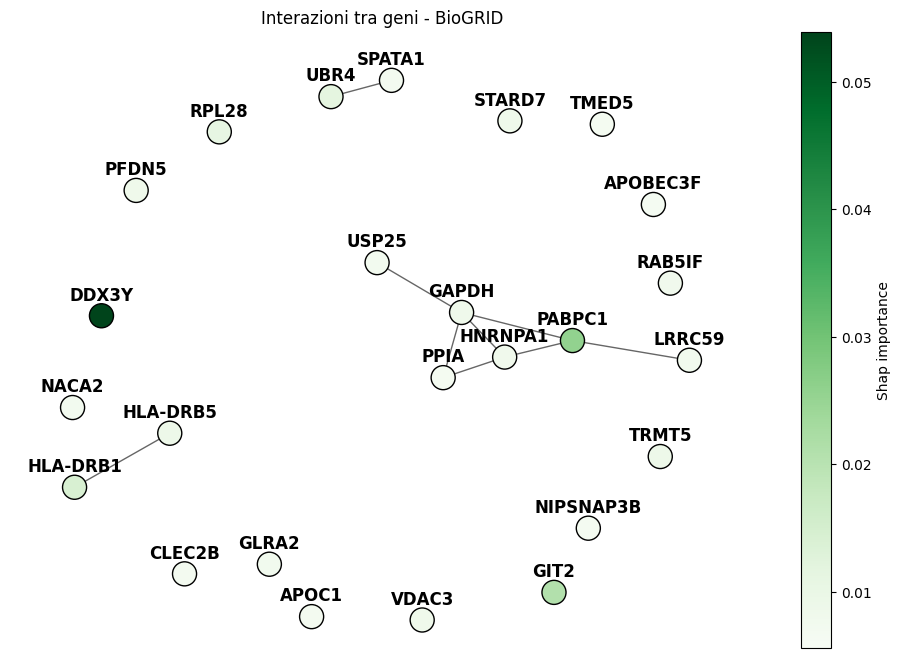

In [14]:
geneList = list(goodIntersect)
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []


i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for node in geneList:
    G.add_node(node)

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con interazioni matrice di correlazione migliori 100 shap importance

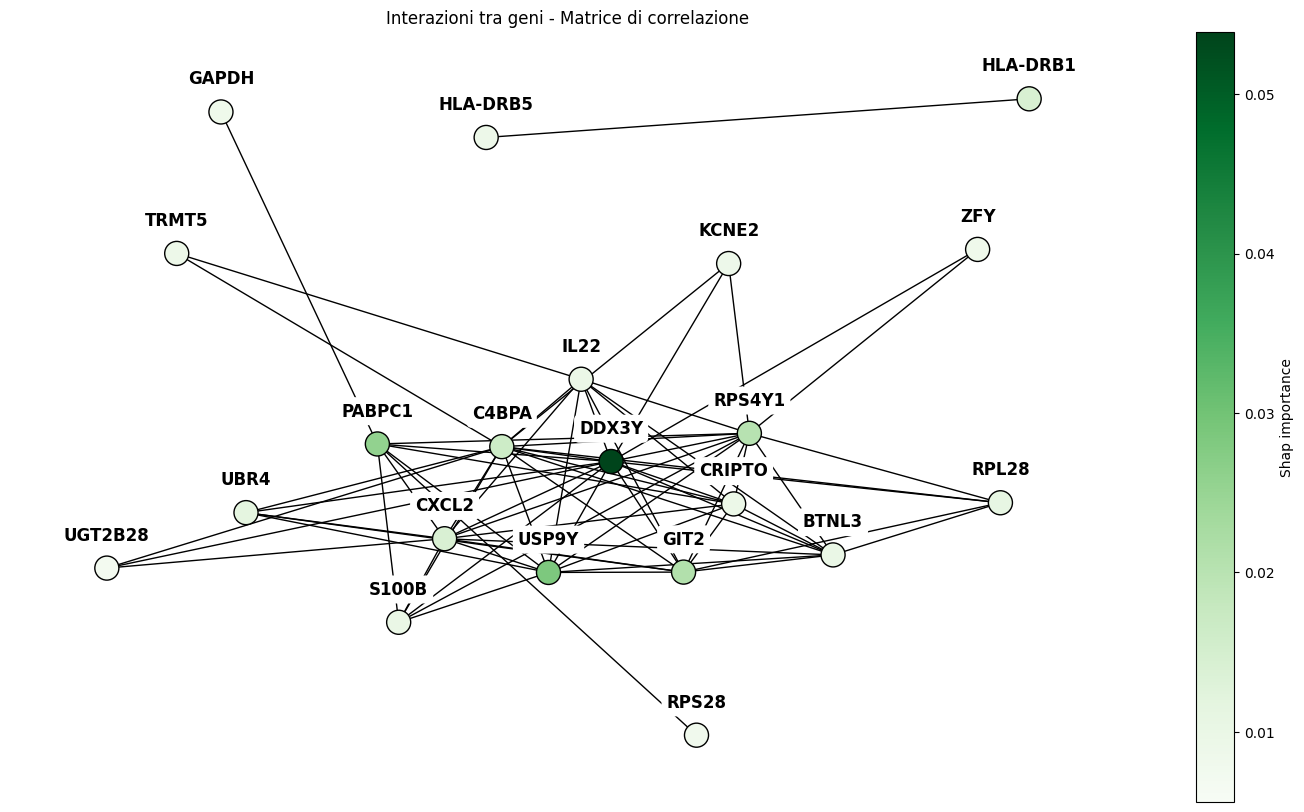

In [17]:
ensembleCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()

G = nx.Graph()

for i in range(ensembleCorr.shape[0]):
    for j in range(ensembleCorr.shape[1]):
        if abs(ensembleCorr.iloc[i, j]) > 0.4 and i != j:
            G.add_edge(ensembleCorr.columns[i], ensembleCorr.columns[j])

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]
pos = nx.spring_layout(G, k=1)
fig, ax = plt.subplots(figsize=(18,10))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.1) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Disegna gli archi
nx.draw_networkx_edges(G, pos, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()

Grafo ottenuto da matrice di correlazione con intersezione migliori geni SHAP e ablation

{'PHB2', 'RPS2', 'RPL28', 'APOBEC3F', 'TRMT5', 'BAZ1B', 'PABPC1', 'APOO', 'NACA2', 'PPIA', 'USP25', 'PFDN5', 'HLA-DRB1', 'DDX3Y', 'FSHB', 'SIT1', 'CLEC2B', 'FKBP11', 'LRRC59', 'GALNT1', 'NIPSNAP3B', 'UBR4', 'GLRA2', 'APOC1', 'HNRNPA1', 'HLA-DRB5', 'EXOSC8', 'VDAC3', 'STARD7', 'RPL13A', 'SPATA1', 'MIR22HG', 'TMED5', 'GIT2', 'JPT1', 'GAPDH', 'CTNNBL1', 'RAB5IF'}
               PHB2      RPS2     RPL28  APOBEC3F     TRMT5     BAZ1B  \
PHB2       1.000000 -0.003132  0.069474  0.024589 -0.039988 -0.054311   
RPS2      -0.003132  1.000000 -0.001354 -0.145271  0.086220 -0.007115   
RPL28      0.069474 -0.001354  1.000000  0.104341  0.329777  0.000446   
APOBEC3F   0.024589 -0.145271  0.104341  1.000000  0.034085  0.129524   
TRMT5     -0.039988  0.086220  0.329777  0.034085  1.000000  0.108771   
BAZ1B     -0.054311 -0.007115  0.000446  0.129524  0.108771  1.000000   
PABPC1    -0.062055  0.031334  0.157776 -0.028429  0.177822  0.063255   
APOO       0.094206 -0.048377  0.134736  0.101299  0.

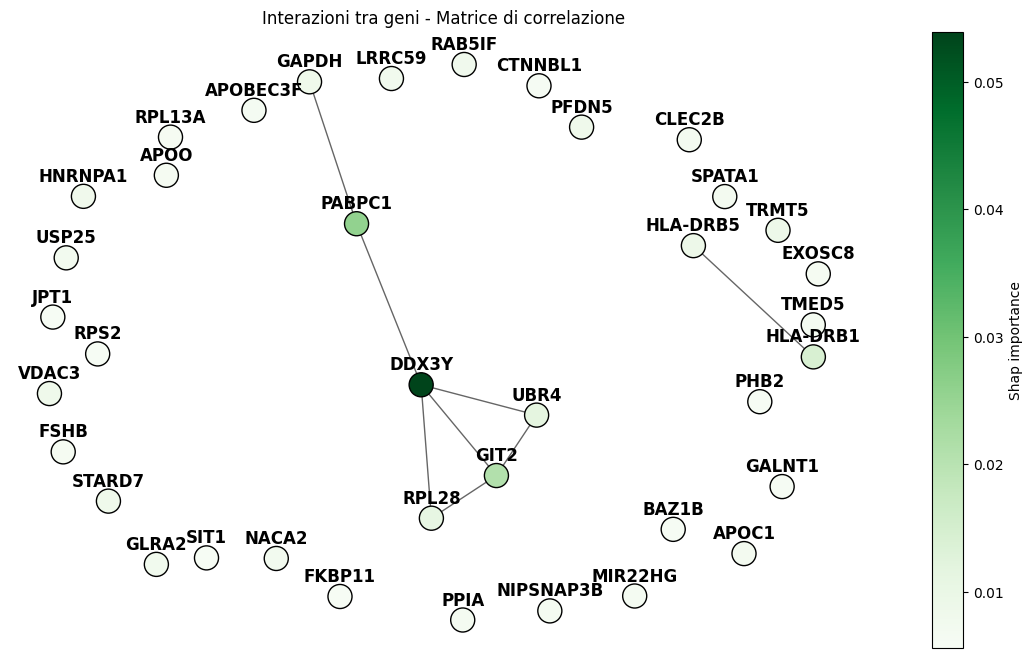

In [30]:
intersect = set(list(bestFeatures.keys())).intersection(set(list(expl_sorted.keys())[:]))

print(intersect)

intersectCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(intersect)].corr()

print(intersectCorr)

G = nx.Graph()

for i in range(intersectCorr.shape[0]):
    G.add_node(intersectCorr.columns[i])
    for j in range(intersectCorr.shape[1]):
        if abs(intersectCorr.iloc[i, j]) >= 0.4 and i != j:
            print(intersectCorr.columns[i], intersectCorr.columns[j])
            G.add_edge(intersectCorr.columns[i], intersectCorr.columns[j])

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.8)
fig, ax = plt.subplots(figsize=(14,8))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()